In [3]:
import json
import re
import pymysql
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
pd.options.display.float_format = "{:.0f}".format

In [4]:
with open('../../server/app/config.json') as json_data_file:
    data = json.load(json_data_file)
    url = data['SQLALCHEMY_DATABASE_URI']
user, password, host, database = re.match('mysql://(.*?):(.*?)@(.*?)/(.*)', url).groups()
conn = pymysql.connect(host=host,port=3306,user=user,passwd=password,db=database)

In [19]:
query_39732c="""
    SELECT  TIMESTAMP,
            DATA->'$.DATA.NODE.FREE_HEAP' AS FREE_HEAP,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX0' AS MUX0,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX1' AS MUX1,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX2' AS MUX2,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX3' AS MUX3,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX4' AS MUX4,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX5' AS MUX5,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX6' AS MUX6,
            DATA->'$.DATA.CAPACITIVEMOISTURE.MUX7' AS MUX7
    FROM OASIS_DATA
    WHERE NODE_ID='oasis-39732c'
    ORDER BY TIMESTAMP asc
    """
df = pd.read_sql_query(query_39732c, conn).astype(int)
query_397c0e="""
    SELECT  TIMESTAMP,
            DATA->'$.DATA.DHT.TEMPERATURE' AS TEMPERATURE,
            DATA->'$.DATA.DHT.HUMIDITY' AS HUMIDITY
    FROM OASIS_DATA
    WHERE NODE_ID='oasis-397c0e'
    ORDER BY TIMESTAMP asc
    """
dft = pd.read_sql_query(query_397c0e, conn).astype(int)

In [13]:
print("Interval:", df['TIMESTAMP'][1] - df['TIMESTAMP'][0], "secs")
print("Duration:", int(df['TIMESTAMP'].tail(1) - df['TIMESTAMP'][0])/3600, "hrs")

Interval: 60 secs
Duration: 12.05 hrs


In [14]:
df[['FREE_HEAP','MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].describe()

,FREE_HEAP,MUX0,MUX1,MUX2,MUX3,MUX4,MUX5,MUX6,MUX7
count,724,724,724,724,724,724,724,724,724
mean,33487,245,245,262,248,253,273,541,257
std,27,7,7,7,7,7,7,160,8
min,32816,228,229,242,231,236,258,277,240
25%,33488,240,241,256,244,248,268,327,250
50%,33488,244,245,261,248,253,272,632,257
75%,33488,250,250,268,254,258,280,677,265
max,33656,258,258,278,260,266,286,704,273


In [ ]:
df[['FREE_HEAP','MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].describe()

In [21]:
dft[['TEMPERATURE','HUMIDITY']].describe()

,TEMPERATURE,HUMIDITY
count,1448,1448
mean,27,22
std,1,8
min,25,14
25%,26,17
50%,27,18
75%,27,29
max,35,43


In [23]:
df[['FREE_HEAP','MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].describe()

,FREE_HEAP,MUX0,MUX1,MUX2,MUX3,MUX4,MUX5,MUX6,MUX7
count,724,724,724,724,724,724,724,724,724
mean,33487,245,245,262,248,253,273,541,257
std,27,7,7,7,7,7,7,160,8
min,32816,228,229,242,231,236,258,277,240
25%,33488,240,241,256,244,248,268,327,250
50%,33488,244,245,261,248,253,272,632,257
75%,33488,250,250,268,254,258,280,677,265
max,33656,258,258,278,260,266,286,704,273


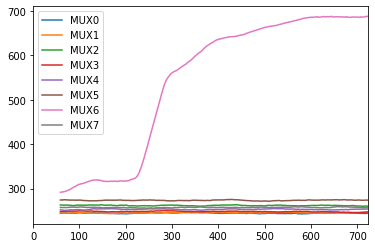

In [22]:
df[['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']].rolling(60).mean().plot()

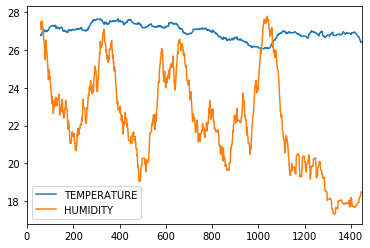

In [26]:
dft[['TEMPERATURE','HUMIDITY']].rolling(60).mean().plot()